# Imports + Helper functions (Train__single_epoch)

In [ ]:
#  PyTorch
import time
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset, random_split
import torch.nn.functional as F
#  torchvision
import torchvision
from torchvision import transforms, datasets
from torchsummary import summary
#  Ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# move the model to the GPU , if there any ;)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Function for a single Epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_model(model,epoch):
  model.train()  # Set model to training mode
  total_loss = 0
  correct = 0
  total = 0
  # loop over all batches
  for index, (inputs,targets) in enumerate(trainloader):

    # Put the data on gpu - if there is one
    inputs , targets = inputs.to(device), targets.to(device)

    # set gradients to zero
    optimizer.zero_grad()

    # calculate the forward pass -> predictions
    outputs = model(inputs)
    # print(f'outputs dtype: {outputs.dtype}')  # Should be torch.float32
    # print(f'targets dtype: {targets.dtype}')  # Should be torch.long

    # now loss calculations
    loss = criterion(outputs, targets)

    # now backprob
    loss.backward()
    # now parameter update
    optimizer.step()

    # this is to accomulate the loss over the batches, then calculate the average per batch by deviding by the no. of batches
    total_loss += loss.item()
    values,indices = outputs.max(1)
    total += targets.size(0)
    correct += indices.eq(targets).sum().item()

    # Compute average loss and accuracy for the epoch
    # Print statistics every few batches
    if index % 200 == 0:
        print(f'Epoch [{epoch}], Batch [{index}/{len(trainloader)}], '
              f'Loss: {total_loss/(index+1):.4f}, '
              f'Accuracy: {100.*correct/total:.2f}%')
  avg_train_loss = total_loss / len(trainloader)
  train_accuracy = 100. * correct / total

  # Store the values for plotting later
  train_losses.append(avg_train_loss)
  train_accuracies.append(train_accuracy)




# Evaluation Function
def model_validation(model,epoch,validset):
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, targets in validset:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Accumulate statistics
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_val_loss = test_loss / len(validset)
    val_accuracy = 100. * correct / total
    print(f'Epoch {epoch} Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')
        # Compute average loss and accuracy for the validation set

    # Store the values for plotting later
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)


def plot_metrics():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # plot the loss over epochs
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss over Epochs')
    ax1.legend()

    # plot the accuracy over epochs
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()
def plot_metrics_test():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # plot the loss over epochs
    ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss over Epochs')
    ax1.legend()

    # plot the accuracy over epochs
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy over Epochs')
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


#  SECTION 1. Training Basic CNNs From Scratch (40%)

CIFAR-10 is a popular image classification dataset, with 50,000 training samples and 10,000 test samples,
and can be loaded from libraries like Keras and PyTorch. Your task is to set up a basic CNN (similar to
the one at the end of Lecture 1), train it from scratch on the CIFAR-10 training set, experiment with a
few different architectures and regularisation strategies, and ultimately evaluate your final model on the
hold-out test set.
Importantly, do not look at your model’s classification performance on the test set while experimenting
with different architectures and hyperparameters. Instead, use a portion of the training set for validation
throughout, and only evaluate your final model on the test set once, for an unbiased indication of how the
model would generalise.

## Data Preparation -CIFAR10 DATASET

In [ ]:
transform_train = transforms.Compose(
    [transforms.ToTensor()])



batch_size = 64
train_ratio = 0.8
validation_ratio = 0.2
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#  preparing the data int train, valdation and test


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_train)

dataset_size = len(trainset)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,

                                         shuffle=False, num_workers=2)



#  prepating dat iterators
training_iterator = iter(trainloader)
validation_iterator = iter(validationloader)
test_iterator = iter(testloader)


100%|██████████| 170498071/170498071 [00:04<00:00, 42404694.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
print(f'Total dataset size: {dataset_size + 10000}')
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(validation_dataset)}')
print(f'test dataset size: {len(test_dataset)}')

Total dataset size: 60000
Training dataset size: 40000
Validation dataset size: 10000
test dataset size: 10000


### Comment on The Data.

We now have 40k data sample for training, 10k for validation and 10k for test. the test set will not be usen until the final check of the model.


### Show Example From The Dataset: visualize my dataset

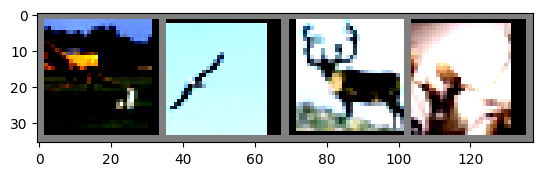

plane bird  deer  deer 


In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
data = next(training_iterator)
images, labels = data[0][:4] , data[1][:4]
# show images
imshow(torchvision.utils.make_grid(images))
# classes[labels]
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## PART A -  Building a Simple CNN:

### Basic Model - Lecture Example :

In [ ]:
class CNN(nn.Module):
  def __init__(self,classes = 10):
    super(CNN, self).__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels = 6,kernel_size=5)
    self.conv2 = nn.Conv2d(6,16,5,stride = 1)

    # pooling layer
    self.pool =  nn.AvgPool2d(kernel_size=2, stride=2)

  # fully connected Layers
    self.fc1 = nn.Linear(16*5*5, 128)
    self.fc2 = nn.Linear(128, 84)
    self.fc3 = nn.Linear(84, classes)


  def forward(self,x):

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x= torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    # out put
    x = self.fc3(x)

    return x

#  Creating an instance of the Model

simple_cnn = CNN(10)
simple_cnn.to(device)


# observe the model layers, input dimentions, and no. of trainable parameters
summary(simple_cnn, input_size=(3, 32, 32))

# see what device we are operating on
print(f" The device working right now is: {device}")

# Set loss funciton and optimizer
optimizer = torch.optim.Adam(simple_cnn.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_model(simple_cnn,epoch)
    model_validation(simple_cnn,epoch,validationloader)

# Save the model
torch.save(simple_cnn.state_dict(), 'simple_cnn.pth')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 128]          51,328
            Linear-6                   [-1, 84]          10,836
            Linear-7                   [-1, 10]             850
Total params: 65,886
Trainable params: 65,886
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.25
Estimated Total Size (MB): 0.32
----------------------------------------------------------------
 The device working right now is: cuda
Epoch [0], Batch [0/625], Loss: 2.3123, Accuracy: 9.38%
Epoch [0], Ba

#### Comment on the simple model architecture:
This is a very simple CNN model- 2 convolutional layers 2 pooling layers and three fully connected layers, with relatively few parameters and without any regularization used, this will serve as a good baseline to compare future improvemnets

### Going to slightly bigger model

In [ ]:
class CNNModel(nn.Module):
  def __init__(self,num_classes):
    super(CNNModel,self).__init__()
    self.features = nn.Sequential(

        # first conv layer
        nn.Conv2d(in_channels = 3 , out_channels=32 , kernel_size=3 , stride = 1, padding = 1 ), # 32,32
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2 , stride = 2), # 16,16
        nn.Conv2d(in_channels = 32 , out_channels=64 , kernel_size=3 , stride = 1 , padding = 1 ), # 16,16
        nn.ReLU(),
        nn.Conv2d(in_channels = 64 , out_channels=32 , kernel_size=3 , stride = 1 , padding = 1 ), # 16,16
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2 , stride = 2),   #8,8
    )
    # self.AvgPool2d()
    self.classifier = nn.Sequential(
        nn.Linear(32*8*8, 64),
        nn.ReLU(),
        nn.Linear(64,num_classes)
  )

  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x

#  Creating an instance of the Model
model = CNNModel(10)

# move the model to the GPU , if there any ;)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# observe the model layers, input dimentions, and no. of trainable parameters
summary(model, input_size=(3, 32, 32))

# see what device we are operating on
print(f" The device working right now is: {device}")

# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

model = CNNModel(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_model(model,epoch)
    model_validation(model,epoch,validationloader)

# Save the model
torch.save(model.state_dict(), 'cnn.pth')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 32, 16, 16]          18,464
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Linear-9                   [-1, 64]         131,136
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 169,642
Trainable params: 169,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

#### Comment
As we can see, using these two simple models and after training for 5 epoch, the accuracy on the validation set is increased from 51% to 65%.

my observation : bigger model -> better result

## PART B - Trying different Achitectures and Regularization

### Data Augmentation + Normalization Process

In [ ]:
#  Crop + flip , normalize to increase diversity and avoid overfitting
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])


batch_size = 64
train_ratio = 0.8
validation_ratio = 0.2
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


#  preparing the data int train, valdation and test


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_train)

dataset_size = len(trainset)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,

                                         shuffle=False, num_workers=2)



#  prepating dat iterators
training_iterator = iter(trainloader)
validation_iterator = iter(validationloader)
test_iterator = iter(testloader)


100%|██████████| 170498071/170498071 [00:02<00:00, 57849217.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Observing the effects of data augmentation and Normalization + Bigger Model (Total params: 2,168,362)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 32, 32, 32]           9,248
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 512]       2,097,664
            Linear-8                   [-1, 10]           5,130
Total params: 2,168,362
Trainable params: 2,168,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.85
Params size (MB): 8.27
Estimated Total Size (MB): 9.13
----------------------------------------------------------------
Epoch [0], Batch [0/625], Loss: 2.3056

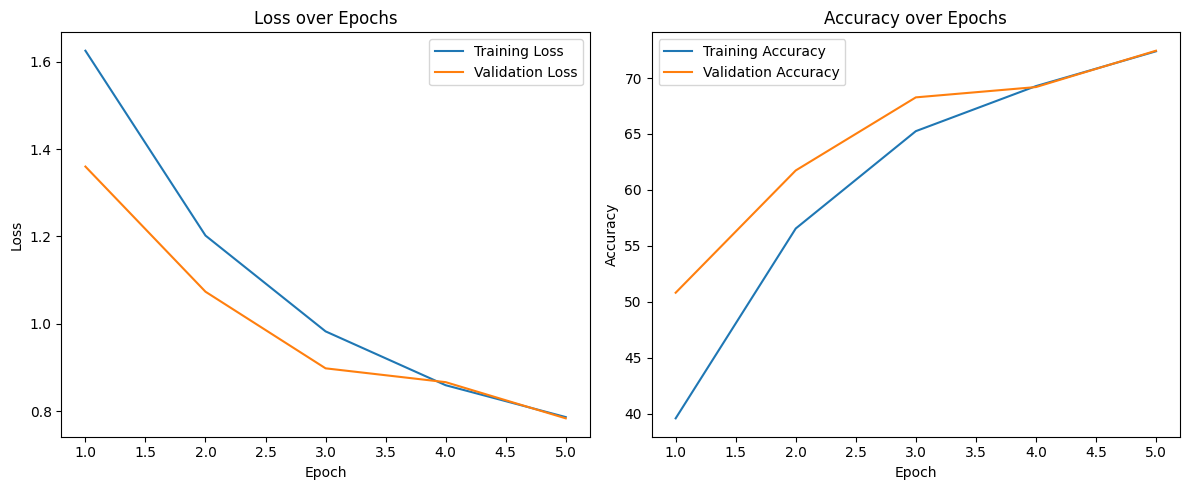

In [ ]:
class AsimNet(nn.Module):
  def __init__(self,num_classes):
      super(AsimNet,self).__init__()
      # convolutional layers
      # input shape is (3,32,32)
      self.conv1 = nn.Conv2d(in_channels = 3 , out_channels=32 , kernel_size=3 , padding = 1 )
      self.conv2 = nn.Conv2d(in_channels = 32 , out_channels=32 , kernel_size=3 , padding = 1 )
      self.conv3 = nn.Conv2d(in_channels = 32 , out_channels=64 , kernel_size=3 , padding = 1 )
      self.conv4 = nn.Conv2d(in_channels = 64 , out_channels=64 , kernel_size=3 , padding = 1 )
      # Pooling layers
      self.pool = nn.MaxPool2d(kernel_size = 2 , stride = 2) # --> output shape is (16 x 16)
      # Fully connected layers
      self.fc1 = nn.Linear(64*8*8, 512)
      self.fc2 = nn.Linear(512, num_classes)

  def forward(self,x):

    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool(x)

    # Flatten
    x = x.view(-1, 64 * 8 * 8)

    # the classifier
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

model = AsimNet(10).to(device)
summary(model, input_size=(3, 32, 32))
# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
tic = time.time()
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    train_model(model,epoch)
    model_validation(model,epoch,validationloader)
toc = time.time()
print(f" Training time = {toc-tic : .2f}")

# plot the accuracy and loss
plot_metrics()

# Save the model
torch.save(model.state_dict(), 'Asim.pth')

#### Comment:

This is a bigger model with millions of parameters, more convolutional layers, more channels and more depth.

Observation: indeed the regularization + increasing the model size corresponts to a considerable improvement in the performance

now we are on 72% accuracy


### Now we try Dropout + Yet Another Bigger Model (Total params: 9,074,218) + More Epochs

#### Dropout

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
            Conv2d-2           [-1, 96, 32, 32]          41,568
         MaxPool2d-3           [-1, 96, 16, 16]               0
           Dropout-4           [-1, 96, 16, 16]               0
            Conv2d-5          [-1, 192, 16, 16]         166,080
            Conv2d-6          [-1, 256, 16, 16]         442,624
         MaxPool2d-7            [-1, 256, 8, 8]               0
           Dropout-8            [-1, 256, 8, 8]               0
            Linear-9                  [-1, 512]       8,389,120
           Linear-10                   [-1, 64]          32,832
          Dropout-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 9,074,218
Trainable params: 9,074,218
Non-trainable params: 0
---------------------------

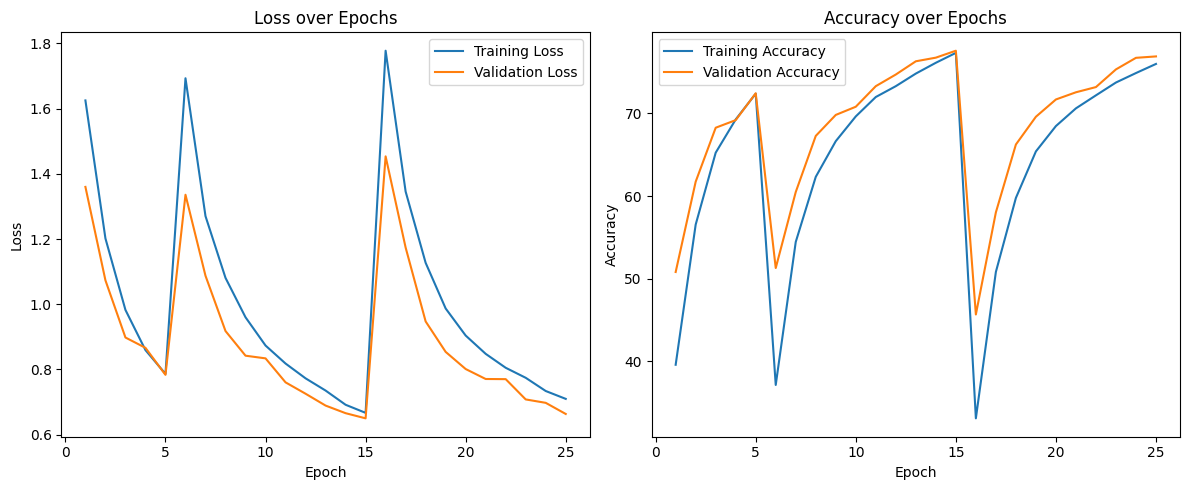

In [ ]:
class AsimNet_dropout(nn.Module):
  def __init__(self,num_classes):
      super(AsimNet_dropout,self).__init__()
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
      self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
      self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
      self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
      self.pool = nn.MaxPool2d(2,2)
      self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
      self.fc2 = nn.Linear(in_features=512, out_features=64)
      self.Dropout = nn.Dropout(0.25)
      self.fc3 = nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
      x = F.relu(self.conv1(x)) #32*32*48
      x = F.relu(self.conv2(x)) #32*32*96
      x = self.pool(x) #16*16*96
      x = self.Dropout(x)
      x = F.relu(self.conv3(x)) #16*16*192
      x = F.relu(self.conv4(x)) #16*16*256
      x = self.pool(x) # 8*8*256
      x = self.Dropout(x)
      x = x.view(-1, 8*8*256) # reshape x
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.Dropout(x)
      x = self.fc3(x)
      return x
#  Creating an instance of the Model
Asim_model = AsimNet_dropout(10)

# move the model to the GPU , if there any ;)
Asim_model.to(device)

# observe the model layers, input dimentions, and no. of trainable parameters
summary(Asim_model, input_size=(3, 32, 32))

# see what device we are operating on
print(f" The device working right now is: {device}")

# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(Asim_model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
tic = time.time()
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_model(Asim_model,epoch)
    model_validation(Asim_model,epoch,validationloader)
toc = time.time()
print(f" Training time = {toc-tic : .2f} seconds")

# plot the accuracy and loss
plot_metrics()
# Save the model
torch.save(model.state_dict(), 'test.pth')

#### Comment

Good improvement in model performance, the combination of big model with deep layer and the large no. of parameters + dropout technique seems th best strategy

Now we are on 77% accuracy

### Trying Batch Norm - IT OVERFITS unless it is regularized well

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
       BatchNorm2d-2           [-1, 48, 32, 32]               0
            Conv2d-3           [-1, 96, 32, 32]          41,568
       BatchNorm2d-4           [-1, 96, 32, 32]               0
         MaxPool2d-5           [-1, 96, 16, 16]               0
           Dropout-6           [-1, 96, 16, 16]               0
            Conv2d-7          [-1, 192, 16, 16]         166,080
       BatchNorm2d-8          [-1, 192, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         442,624
      BatchNorm2d-10          [-1, 256, 16, 16]               0
        MaxPool2d-11            [-1, 256, 8, 8]               0
          Dropout-12            [-1, 256, 8, 8]               0
           Linear-13                  [-1, 512]       8,389,120
      BatchNorm1d-14                  [

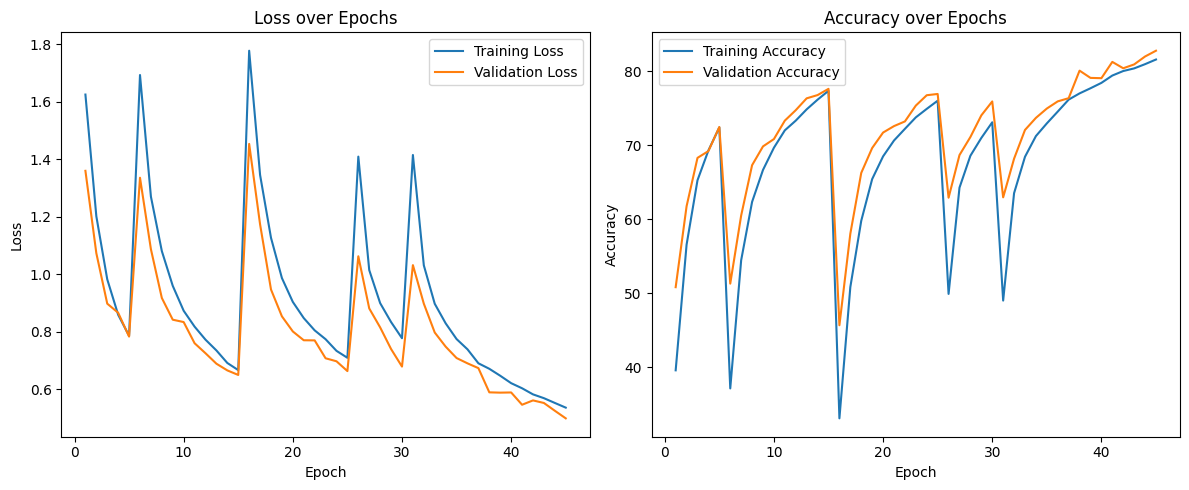

In [ ]:
class BN_AsimNet(nn.Module):
  def __init__(self,num_classes):
      super(BN_AsimNet,self).__init__()
      # convolutional layers
      # input shape is (3,32,32)
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1))
      self.bn1 = nn.BatchNorm2d(48,affine=False)
      self.conv2 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1))
      self.bn2 = nn.BatchNorm2d(96,momentum=0.5,affine=False)
      self.conv3 = nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1))
      self.bn3 = nn.BatchNorm2d(192,momentum=0.5,affine=False)

      self.conv4 = nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1))
      self.bn4 = nn.BatchNorm2d(256,momentum=0.5,affine=False)


      # Pooling layers

      self.pool = nn.MaxPool2d(kernel_size = 2 , stride = 2) # --> output shape is (16 x 16)
      self.Dropout = nn.Dropout(0.25)

      # Fully connected layers
      self.fc1 = nn.Linear(in_features=8*8*256, out_features=512)
      self.bn5 = nn.BatchNorm1d(512,momentum=0.5,affine=False)
      self.fc2 = nn.Linear(in_features=512, out_features=64)
      self.bn6 = nn.BatchNorm1d(64)
      self.fc3 = nn.Linear(in_features=64, out_features=num_classes)

  def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))        #32*32*48
      x = F.relu(self.bn2(self.conv2(x)))                   #32*32*96
      x = self.pool(x)              #16*16*96
      x = self.Dropout(x)
      x = F.relu(self.bn3(self.conv3(x))) #16*16*192
      x = F.relu(self.bn4(self.conv4(x))) #16*16*256
      x = self.pool(x) # 8*8*256
      x = self.Dropout(x)
      x = x.view(-1, 8*8*256) # flaten x
      x = F.relu(self.bn5(self.fc1(x)))
      x = F.relu(self.bn6(self.fc2(x)))
      x = self.Dropout(x)
      x = self.fc3(x)
      return x


#  Creating an instance of the Model
Asim_model = BN_AsimNet(10)

# move the model to the GPU , if there any ;)
Asim_model.to(device)

# observe the model layers, input dimentions, and no. of trainable parameters
summary(Asim_model, input_size=(3, 32, 32))

# see what device we are operating on
print(f" The device working right now is: {device}")

# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(Asim_model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

import time
tic = time.time()
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    train_model(Asim_model,epoch)
    model_validation(Asim_model,epoch,validationloader)
toc = time.time()
print(f" Training time = {toc-tic:.2f} seconds")
plot_metrics()

# Save the model
torch.save(Asim_model.state_dict(), 'test.pth')


#### THIS IS THE BEST PERFORMING MODEL, with Validation Accuracy: 82.74%

#### Comment

        # My observation after many trials is that dropout does not improve the accuracy in a small model, but it gives more stable training process overtime, i.e. steady loss decrease overtime

        # at the same time, when combining dropout with bigger models, it gets the best results, joining the power of big models, and preventing overfitting using dropouts

        # And for using Batch norm, looks like this method speeds up the training process but makes the model prone to overfit especially after normalizing the data in the begining. but for a well regularized model, it improves the model performance

        # And the best Model so far is the BN_AsimNet model with 9m parameter  with data augmentation and dropout and batch norm, so we are going to try th holdout test set on our best performing model

### Final test

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,344
       BatchNorm2d-2           [-1, 48, 32, 32]               0
            Conv2d-3           [-1, 96, 32, 32]          41,568
       BatchNorm2d-4           [-1, 96, 32, 32]               0
         MaxPool2d-5           [-1, 96, 16, 16]               0
           Dropout-6           [-1, 96, 16, 16]               0
            Conv2d-7          [-1, 192, 16, 16]         166,080
       BatchNorm2d-8          [-1, 192, 16, 16]               0
            Conv2d-9          [-1, 256, 16, 16]         442,624
      BatchNorm2d-10          [-1, 256, 16, 16]               0
        MaxPool2d-11            [-1, 256, 8, 8]               0
          Dropout-12            [-1, 256, 8, 8]               0
           Linear-13                  [-1, 512]       8,389,120
      BatchNorm1d-14                  [

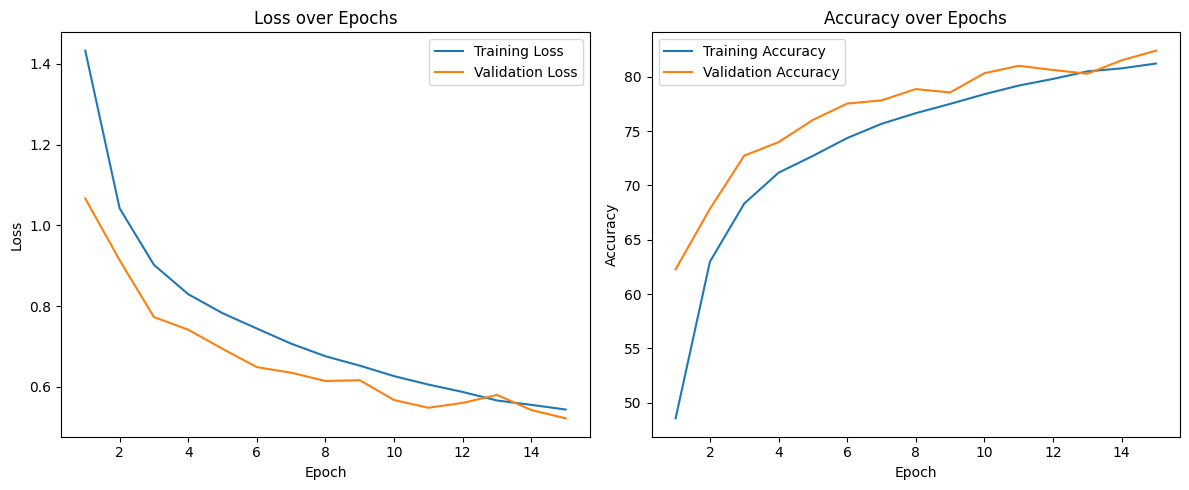

In [ ]:

#  Creating an instance of the Model
Asim_model = BN_AsimNet(10)

# move the model to the GPU , if there any ;)
Asim_model.to(device)

# observe the model layers, input dimentions, and no. of trainable parameters
summary(Asim_model, input_size=(3, 32, 32))

# see what device we are operating on
print(f" The device working right now is: {device}")

# Set up the loss funciton and the optimizer
optimizer = torch.optim.Adam(Asim_model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

import time
tic = time.time()
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    train_model(Asim_model,epoch)
    model_validation(Asim_model,epoch,testloader)
toc = time.time()
print(f" Training time = {toc-tic:.2f} seconds")
plot_metrics()

# Save the model
torch.save(Asim_model.state_dict(), 'test.pth')


#### Final Thoughts

Perfect, great accuracy and generalization to the test set

<font size = 6 color = red > Good </font>